In [136]:
%matplotlib notebook
import numpy as np
import cupy as cp
import sigpy.plot as pl
from scipy.sparse import csr_matrix
import pywt
# device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
def wavMask(dims, scale):
    sx, sy = dims
    res = np.ones(dims)
    NM = np.round(np.log2(dims))
    for n in range(int(np.min(NM)-scale+2)//2):
        res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))] = \
            res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))]/2
    return res


def imshowWAV(Wim, scale=1):
    plt.imshow(np.abs(Wim)*wavMask(Wim.shape, scale), cmap = plt.get_cmap('gray'))

    
def coeffs2img(LL, coeffs):
    LH, HL, HH = coeffs
    return np.vstack((np.hstack((LL, LH)), np.hstack((HL, HH))))


def unstack_coeffs(Wim):
        L1, L2  = np.hsplit(Wim, 2) 
        LL, HL = np.vsplit(L1, 2)
        LH, HH = np.vsplit(L2, 2)
        return LL, [LH, HL, HH]

    
def img2coeffs(Wim, levels=3):
    LL, c = unstack_coeffs(Wim)
    coeffs = [c]
    for i in range(levels-1):
        LL, c = unstack_coeffs(LL)
        coeffs.insert(0,c)
    coeffs.insert(0, LL)
    return coeffs
    
    
def dwt2(im):
    coeffs = pywt.wavedec2(im, wavelet='db4', mode='per', level=3)
    Wim, rest = coeffs[0], coeffs[1:]
    for levels in rest:
        Wim = coeffs2img(Wim, levels)
    return Wim


def idwt2(Wim):
    coeffs = img2coeffs(Wim, levels=3)
    return pywt.waverec2(coeffs, wavelet='db4', mode='per')

In [138]:
B.shape

(256, 256)

In [139]:
dwt2(cp.asnumpy(B)).shape

(256, 256)

In [140]:
def M_forward(M,c):
    return cp.matmul(M,c)
    

In [141]:
def C_forward(C,m):
    return cp.matmul(m,C)


In [142]:
def M_adjoint(M,x):
    return cp.matmul(cp.conj(M.T),x)

In [143]:
def C_adjoint(C,x):
    return cp.matmul(x,cp.conj(C.T))

In [144]:
#Verification
n=256
tdim=24
M=cp.random.rand(n*tdim,n)+1j*cp.random.rand(n*tdim,n)
C=cp.random.rand(n,n)+1j*cp.random.rand(n,n)
x=cp.random.rand(n*tdim,n)+1j*cp.random.rand(n*tdim,n)

In [145]:
cp.dot(cp.conj(C.T),M_adjoint(M,x))

array([[403617.71762371-390490.39039443j,
        405722.55088155-387925.00021294j,
        405481.2919431 -386192.05625494j, ...,
        405106.64534881-388446.70814195j,
        407138.07265348-390919.69063781j,
        407292.96250364-385543.6147097j ],
       [372540.39632027-398226.15465988j,
        374610.52917869-395649.95478663j,
        374494.43582979-393948.2036868j , ...,
        374040.63503349-396197.50602867j,
        375922.9653471 -398628.25597683j,
        376292.06726137-393514.54931359j],
       [402901.46795565-421304.1995897j ,
        405091.64091652-418765.47751186j,
        404952.37322662-416890.84960168j, ...,
        404603.15750964-419159.67969607j,
        406490.34683995-421735.49404528j,
        406771.06625382-416167.59854853j],
       ...,
       [364001.28317325-384927.72994655j,
        366134.32287201-382429.22532182j,
        365978.74927175-380860.54102213j, ...,
        365522.64512084-382979.71368863j,
        367375.03536211-385369.55022256j,

In [146]:
cp.dot(C_forward(C,M).T.conj(),x)

array([[403617.71762371-390490.39039444j,
        405722.55088155-387925.00021294j,
        405481.29194309-386192.05625494j, ...,
        405106.64534881-388446.70814195j,
        407138.07265348-390919.69063781j,
        407292.96250364-385543.6147097j ],
       [372540.39632027-398226.15465988j,
        374610.52917869-395649.95478663j,
        374494.43582979-393948.2036868j , ...,
        374040.63503349-396197.50602867j,
        375922.9653471 -398628.25597683j,
        376292.06726137-393514.54931359j],
       [402901.46795565-421304.1995897j ,
        405091.64091652-418765.47751186j,
        404952.37322662-416890.84960168j, ...,
        404603.15750964-419159.67969607j,
        406490.34683995-421735.49404529j,
        406771.06625382-416167.59854853j],
       ...,
       [364001.28317325-384927.72994655j,
        366134.32287201-382429.22532182j,
        365978.74927175-380860.54102213j, ...,
        365522.64512084-382979.71368863j,
        367375.03536211-385369.55022256j,

In [147]:
def soft_thresh_complex_np(x, l):
    return np.sign(abs(x)) * np.maximum(np.abs(x) - l, 0.)*np.exp(1j*np.angle(x))

In [148]:
def soft_thresh_complex(x, l):
    return cp.sign(abs(x)) * np.maximum(cp.abs(x) - l, 0.)*cp.exp(1j*cp.angle(x))

In [149]:
M.shape

(6144, 256)

In [150]:
A.shape

(6144, 256)

In [151]:
p0 = (A.T.dot(A))

In [152]:
e = cp.linalg.eigvalsh(p0)

In [153]:
float(e[-1])

22.498533080984792

In [154]:
abs(e[0]).max()

array(0.85369964)

In [155]:
def ista(C1,M1,L,lamda,CS,x,N):
    C0=C1
    M0=M1
    converge = []
    for i in range(N):
        L = float(cp.linalg.eigvalsh(M0.T.dot(M0))[-1])
        for j in range(100):
            C01 = C0 - (1/L)*M_adjoint(M0,M_forward(M0,C0)-x)
            w = dwt2(cp.asnumpy(C01))
            C00 = soft_thresh_complex_np(w,CS/L)
            C01 = cp.asarray(idwt2(C00))
            converge.append(cp.linalg.norm(M_forward(M0,C01)-x))
            C0 = C01
        L = float(cp.linalg.eigvalsh(C0.T.dot(C0))[-1])
        for t in range(100):
            w = M0 - (1/L)*C_adjoint(C0,C_forward(C0,M0)-x)
            M01 = soft_thresh_complex(w,lamda/L)
            converge.append(cp.linalg.norm(M_forward(M01,C0)-x))
            M0 = M01
        print(cp.linalg.norm(M_forward(M0,C0)-x))
        cp.save("M0.npy",M0)
        cp.save("C0.npy",C0)
        cp.save("converge.npy",converge)
        
    return M0,C0,converge

In [156]:
import scipy.io 

In [157]:
image_data=scipy.io.loadmat('images.mat')

In [158]:
LPS_image = image_data['LplusS']

<IPython.core.display.Javascript object>


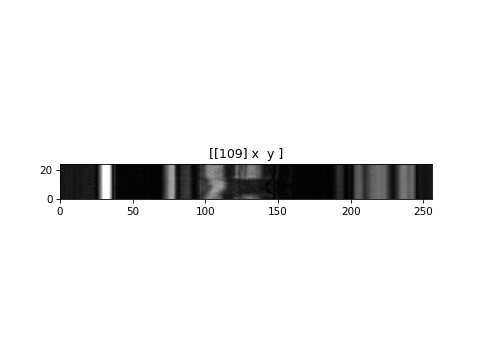

In [159]:
pl.ImagePlot(LPS_image)

In [31]:
LPS_image.shape

(256, 256, 24)

In [32]:
import numpy.matlib

In [63]:
x=LPS_image.transpose(2,0,1).reshape(256*24,256)
C=LPS_image[:,:,1]
M=np.matlib.repmat(np.eye(256,256),24, 1)

In [109]:
C = cp.array(C)
M = cp.array(M)
x = cp.array(x)

In [ ]:
A,B,converge = ista(C,M,1000,0.01,0.01,x,N=200)

15.993447182551225
14.779856212215831
14.24133108504539
13.887788812310752
13.626991118466865
13.421184229053226
13.251328342558327
13.10671972329742
12.980517931652761
12.868290591911567
12.766969545371488
12.674274147032426
12.588490475044527
12.508533101693143
12.433475476216353
12.362674400545828
12.295478102961559
12.231581428155328
12.170786301572278
12.112856465723556
12.057648530251775
12.004962637638386
11.954629628193285
11.906477447452312
11.860349809350494
11.816122979100506
11.773668155264902
11.732875984956776
11.693687691479255
11.656150554655953
11.620210932821731
11.585876882702257
11.553123677486063
11.521910802805046
11.492136184521533
11.463716802206758
11.436541543622107
11.410525292531164
11.385550834823203
11.361543183216753
11.3383861843907
11.315996458602726
11.294285784658587
11.273189381252276
11.25261526216607
11.232479979714526
11.212735444247057
11.193332519929003
11.174195670486894
11.155291612046662
11.136550950769436
11.11792987709671
11.099404305090868

<IPython.core.display.Javascript object>


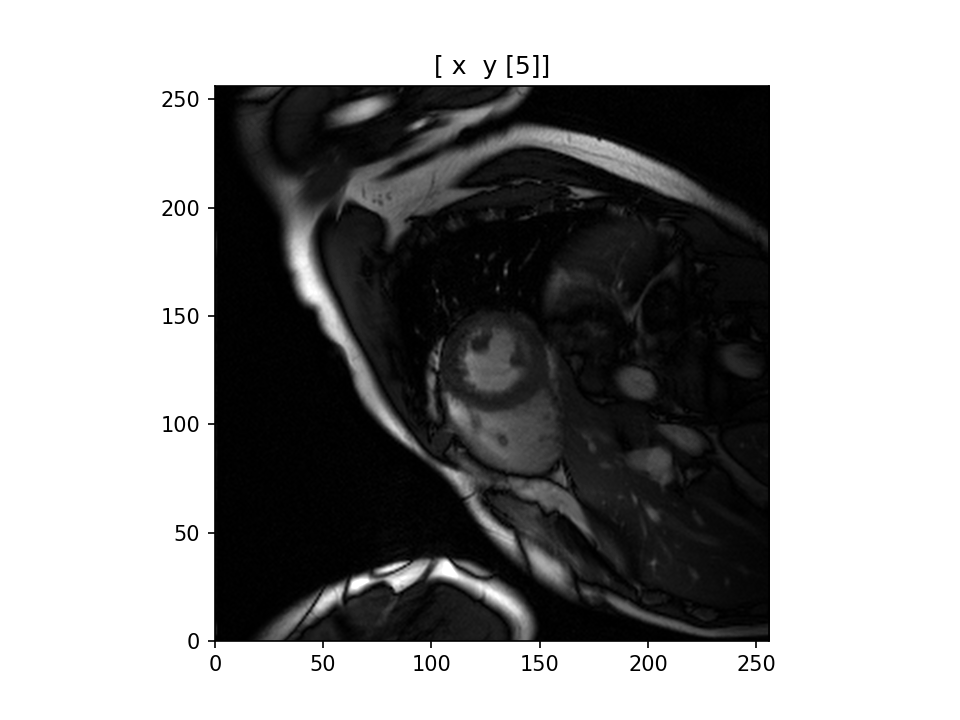

In [38]:
pl.ImagePlot(LPS_image)

In [75]:
LPS_image = cp.array(LPS_image)

In [76]:
rec = A.dot(B).reshape(24,256,256)
org = LPS_image.transpose(2,0,1)

In [77]:
cod = cp.concatenate((rec,org),axis=2)

<IPython.core.display.Javascript object>


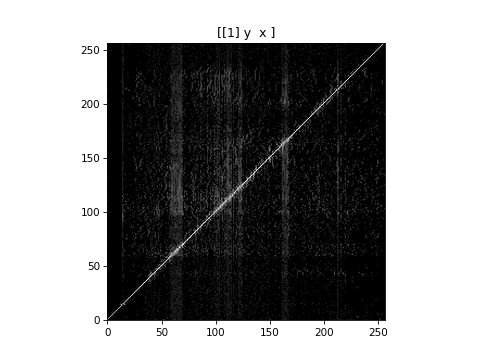

In [135]:
pl.ImagePlot(A.reshape(24,256,256)**(1/3))

<IPython.core.display.Javascript object>


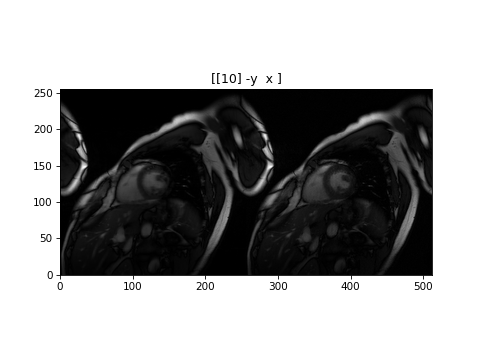

In [129]:
pl.ImagePlot(cod)

In [55]:
(cp.conj(1+1j))

array(1.-1.j)